In [1]:
import sklearn
print(sklearn.__version__)
#result: 1.2.2

1.1.3


In [ ]:
#!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
data.keys()

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [3]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [4]:
X, y = data["data"], data["target"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In [6]:
#here: using Lasso, Ridge and ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

poly_feat_2 = PolynomialFeatures(degree=2) # take this up to 3 and see what happens
X_train_poly = poly_feat_2.fit_transform(X_train)
X_test_poly = poly_feat_2.transform(X_test)

# default parameters of LinearRegression are the same for Lasso
cv_res = []

#names used for visualization later on
names = ["Linear regression", "Lasso regression", "Ridge regression", "ElasticNet regression"]

#for comparing different models always use the default parameter
for model in [LinearRegression(),Lasso(),Ridge(),ElasticNet(l1_ratio=0)]:
    cv_res.append(cross_validate(model,
                                X_train_poly,
                                y_train,
                                cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples (splits each sample into 5 subsamples)
                                return_train_score = True,
                                return_estimator = True,
                                n_jobs = 2))

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+03, tolerance: 2.838e+00
  model = cd_fast.enet_coordinate_descent(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+03, tolerance: 2.873e+00
  model = cd_fast.enet_coordinate_descent(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

Linear regression, num non-zero weights: 105.0
Lasso regression, num non-zero weights: 55.4
Ridge regression, num non-zero weights: 104.0
ElasticNet regression, num non-zero weights: 104.0


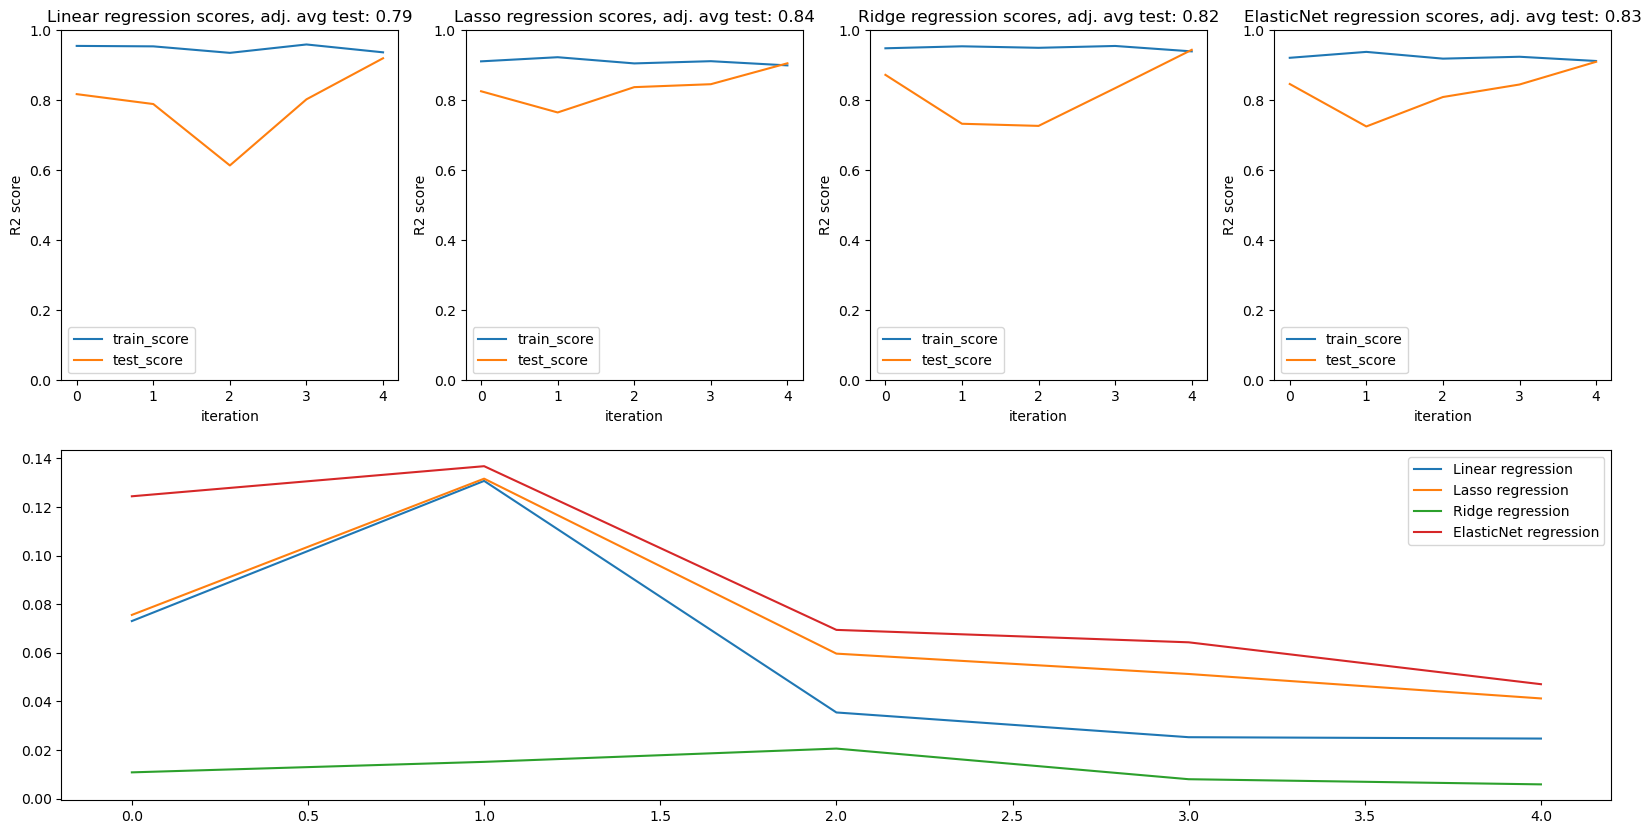

In [7]:
#function: gets the number of nonzero coefficients
def getNonZeroWeights(est):
    return len(est.coef_[est.coef_!=0])

fig = plt.figure(figsize=(20,10))
trainin_time_ax = fig.add_subplot(2,1,2)
for i in range(4):
    name = names[i]  # Assuming `names` is a list of model names
    df_reg = pd.DataFrame(cv_res[i])  # Assuming `cv_res` is a list of results)
    
    #tells us the nonzero weights for each cross-validation
    #then returning coefficients for each estimator
    # Calculate non-zero weights for each CV fold
    df_reg["nonZeroWeights"] = df_reg["estimator"].apply(getNonZeroWeights) 

    #2 rows, 4 columns, iterating over 4 models (index i going from 0 to 3), adding 1 ensures that the subplots start from index 1 (the top left corner) and fill the grid row-wise.
    ax = fig.add_subplot(2,4,i+1)

    # Set title and labels
    ax.set_title(
        name + " scores, adj. avg test: "
        + str(round(df_reg.loc[df_reg["test_score"] > 0]["test_score"].mean(), 2))
    )
    ax.set_xlabel("iteration")
    ax.set_ylabel("R2 score")
    ax.set_ylim(0, 1)

    # Plot training and test scores for each fold
    df_reg[["train_score", "test_score"]].plot(ax=ax)

    # Print average number of non-zero weights
    print(name + ", num non-zero weights:", df_reg["nonZeroWeights"].mean())

    # Plot training time for each model
    df_reg["fit_time"].plot(ax=trainin_time_ax, label=name)

plt.sca(trainin_time_ax)
plt.legend()
plt.show()

# Lasso Regression shows much more consistent performance

# Lasso takes a little "longer" to train, but we can see that differences likely arises due to coordinate descent
# used by Lasso, since when we use L2 regularization using ElasticNet (which uses coordinate descent), we also get
# higher fit times

#result: train scores seem pretty consistent across our models
#lasso has slightly lower train scores, best fitting model (small gap = less overfitting), lasso uses less features (feature selection)
#linear: has overfit our training set (large gap between test and training)
#ridge: heavy overfitting
#time results: lasso takes longer to train but the performance is better
#lasso+elastic use coordinate descent, linear regression uses gradient descent